# Group Equivariant Network

In [1]:
from torchvision.transforms.functional import rotate as torchvision_rotate
import numpy as np
import torch

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class C4:

  @staticmethod
  def product(r: int, s: int) -> int:
    return (r + s) % 4

  @staticmethod
  def inverse(r: int) -> int:
    return (4 - r) % 4


class D4:

  @staticmethod
  def product(a: tuple, b: tuple) -> tuple:
    f = (a[0] + b[0])%2
    if a[0] == 1 and b[0] == 0:
      return (f, C4.product(a[1], C4.inverse(b[1])))
    elif a[0] == 1:
      return (f, C4.product(C4.inverse(a[1]), b[1]))
    return (f, C4.product(a[1], b[1]))


  @staticmethod
  def inverse(g: int) -> int:
    if g[0] == 0:
      return (g[0], C4.inverse(g[1]))
    return (1, g[1])

In [3]:
def rotate(x: torch.Tensor, r: int, n: int=4) -> torch.Tensor:
  if n == 4:
    return x.rot90(r, dims=(-2, -1))
  else:
    angle = (360.0 / n) * r
    if len(x.shape) == 4:
      return torchvision_rotate(x, angle)
    return torchvision_rotate(x.reshape(x.shape[0]*x.shape[1], *x.shape[2:]), angle).reshape(*x.shape)

def rotate_pn(y: torch.Tensor, r: int, n: int=4) -> torch.Tensor:
  assert len(y.shape) >= 3
  assert y.shape[-3] == n

  y = torch.roll(y, r, dims=-3)
  return rotate(y, r, n)

def rotate_p4m(y: torch.Tensor, g: int) -> torch.Tensor:
  assert len(y.shape) >= 3
  assert y.shape[-3] == 8

  f = g // 4
  r = g % 4

  y_split = y.reshape(*y.shape[:-3], 2, 4, *y.shape[-2:])
  if f == 1:
    rolled_y = torch.flip(y_split, dims=[-4, -3, -2])
    y_split = torch.roll(rolled_y, 1, dims=-3)

  return rotate_pn(y_split, r, 4).reshape(*y.shape)

In [4]:
class LiftingConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True, group: str = 'pn', n: int = 4):
    super(LiftingConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.group = group

    assert self.group in ['pn', 'd4'], print('Not implemented')

    if self.group == 'pn':
      self.stabilizer_size = n
      self.rotate_func = lambda w, r: rotate(w, r, self.stabilizer_size)
    elif self.group == 'd4':
      self.stabilizer_size = 8
      self.rotate_func = lambda w, r: torch.rot90(w, k=r, dims=[-2, -1]) if r < 4 else torch.rot90(torch.flip(w, dims=[-2]), k=r, dims=[-2, -1])

    self.weight = None

    self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
    torch.nn.init.normal_(self.weight, mean=0.0, std=1.0 / np.sqrt(out_channels * in_channels))

    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.ones(out_channels)*0.01)

  def build_filter(self) ->torch.Tensor:
    _filter = None
    _bias = None

    _filter = torch.stack([self.rotate_func(self.weight, r) for r in range(self.stabilizer_size)], dim=1)

    if self.bias is not None:
      _bias = self.bias[:, None].expand(-1, self.stabilizer_size)
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, self.stabilizer_size)
    assert _filter.shape == (self.out_channels, self.stabilizer_size, self.in_channels, self.kernel_size, self.kernel_size)

    _filter = _filter.reshape(self.out_channels * self.stabilizer_size, self.in_channels, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * self.stabilizer_size)

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)

    return out.view(-1, self.out_channels, self.stabilizer_size, out.shape[-2], out.shape[-1])

In [5]:
class GroupConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True, group: str = 'pn', n: int = 4):

    super(GroupConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.group = group

    assert self.group in ['pn', 'd4'], print('Not implemented')

    if self.group == 'pn':
      self.stabilizer_size = n
      self.rotate_func = lambda w, r: rotate_pn(w, r, self.stabilizer_size)
    elif self.group == 'd4':
      self.stabilizer_size = 8
      self.rotate_func = rotate_p4m


    self.weight = None

    self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, self.stabilizer_size, kernel_size, kernel_size))
    torch.nn.init.normal_(self.weight, mean=0.0, std=1.0 / np.sqrt(out_channels * in_channels))

    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.ones(out_channels)*0.01)

  def build_filter(self) ->torch.Tensor:

    _filter = None
    _bias = None

    _filter = torch.stack([self.rotate_func(self.weight, r) for r in range(self.stabilizer_size)], dim=1)

    if self.bias is not None:
      _bias = self.bias[:, None].expand(-1, self.stabilizer_size)
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, self.stabilizer_size)
    assert _filter.shape == (self.out_channels, self.stabilizer_size, self.in_channels, self.stabilizer_size, self.kernel_size, self.kernel_size)

    _filter = _filter.reshape(self.out_channels * self.stabilizer_size, self.in_channels * self.stabilizer_size, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * self.stabilizer_size)

    x = x.view(x.shape[0], self.in_channels*self.stabilizer_size, x.shape[-2], x.shape[-1])

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)

    return out.view(-1, self.out_channels, self.stabilizer_size, out.shape[-2], out.shape[-1])

# Segmentation

In [6]:
from skimage.io import imread
import os
from skimage.transform import resize
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torchsummary import summary

from IPython.display import clear_output
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [7]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2023-12-03 01:34:10--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2023-12-03 01:34:11--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc80cb2eed855063ba38da2e48c9.dl.dropboxusercontent.com/cd/0/inline/CIokKddkCjjLqDXfYF5Bc9Pk30CbNFmy_WBkx5NQ3fgOT4rPuEastffRXTsGNXrCRDEqj42Mokp9MCxnHRLmrJXaf0M6c_f1uPS3CzXq1PL9FD5WIHrmQEDqFEhw0rDND38/file# [following]
--2023-12-03 01:34:11--  https://uc80cb2eed855063ba38da2e48c9.dl.dropboxusercontent.com/cd/0/inline/CIokKddkCjjLqDXfYF5Bc9Pk30CbNFmy_WBkx5NQ3fgOT4rPuEastffRXTsGNXrCRDEqj42Mokp9MCxnHRLmrJXaf0M6c_f1uPS3CzXq1PL9FD5WIH

In [8]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [9]:
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [10]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [11]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [12]:
len(lesions)

200

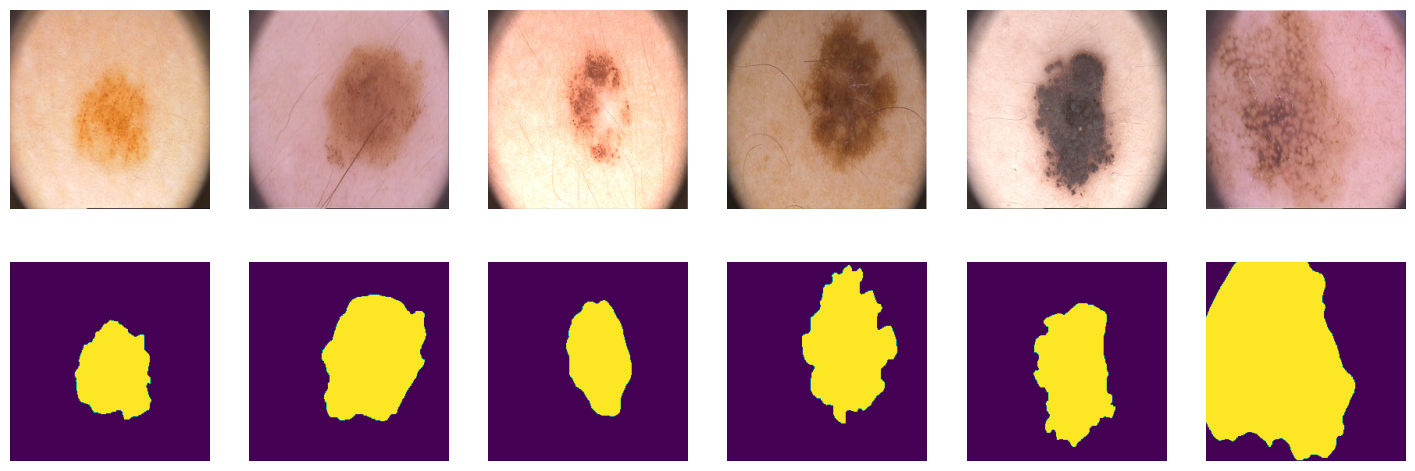

In [13]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [14]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [15]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [16]:
batch_size = 20
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


-----------------------------------------------------------------------------------------

# SegNet

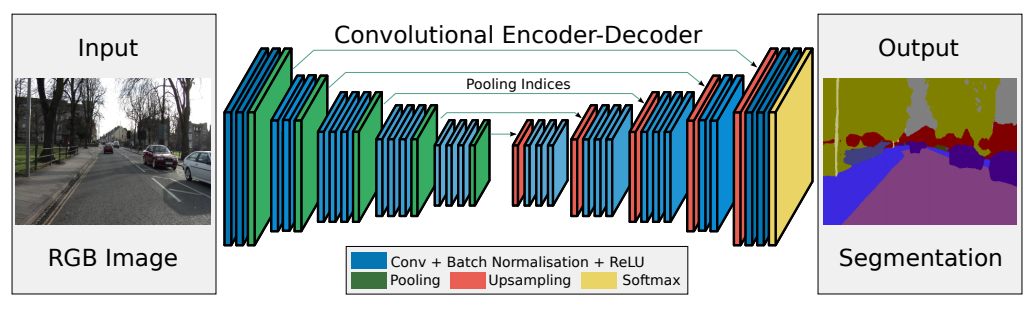

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [19]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 32, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32),
                                       nn.Conv2d(32, 32, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32))
        self.pool0 = nn.MaxPool2d(2)

        self.enc_conv1 = nn.Sequential(nn.Conv2d(32, 64, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(64, 64, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64))
        self.pool1 = nn.MaxPool2d(2);

        self.enc_conv2 = nn.Sequential(nn.Conv2d(64, 128, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(128, 128, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128))
        self.pool2 = nn.MaxPool2d(2);

        self.enc_conv3 = nn.Sequential(nn.Conv2d(128, 256, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(256, 256, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256))
        self.pool3 = nn.MaxPool2d(2);

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(256, 256, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(256, 128, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128))
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear') # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(128, 128, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(128, 64, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64))
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear') # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(64, 64, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(64, 32, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32))
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear') # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(32, 32, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32),
                                       nn.Conv2d(32, 1, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(1))

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x.to(device)))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # decoder
        d0 = self.dec_conv0(self.upsample0(e3))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

In [20]:
class GroupSegNet(nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()

        channels = [1, 16, 32, 64, 128]

        self.enc_layers = [nn.Sequential(LiftingConv2d(input_channels, channels[1], 3, padding=1),
                          nn.ReLU(),
                          nn.BatchNorm3d(channels[1]),
                          GroupConv2d(channels[1], channels[1], 3, padding=1),
                          nn.ReLU(),
                          nn.BatchNorm3d(channels[1]),
                          nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)))]

        for i in range(2, len(channels)):
          self.enc_layers.append(nn.Sequential(GroupConv2d(channels[i - 1], channels[i], 3, padding=1),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i]),
                                               GroupConv2d(channels[i], channels[i], 3, padding=1),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i]),
                                               nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1))))

        self.enc_layers = nn.ModuleList(self.enc_layers)

        self.dec_layers = []
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        for i in range(len(channels) - 1, 0, -1):
          self.dec_layers.append(nn.Sequential(GroupConv2d(channels[i], channels[i], 3, padding=1),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i]),
                                               GroupConv2d(channels[i], channels[i - 1], 3, padding=1),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i - 1])))

        self.dec_layers = nn.ModuleList(self.dec_layers)
        self.pooling = nn.MaxPool3d((4, 1, 1), (1, 1, 1), (0, 0, 0))


    def forward(self, input):
        # encoder
        x = input.to(device)
        for layer in self.enc_layers:
          x = layer(x)

        # decoder
        for layer in self.dec_layers:
          upsampled = self.upsample(x.reshape(x.shape[0] * x.shape[1], *x.shape[2:]))
          upsampled = upsampled.reshape(x.shape[0], x.shape[1], *upsampled.shape[1:])
          x = layer(upsampled)

        output = self.pooling(x)
        return output.reshape(output.shape[0], output.shape[1]*output.shape[2], *output.shape[3:])

In [21]:
model = SegNet().to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
       BatchNorm2d-3         [-1, 32, 256, 256]              64
            Conv2d-4         [-1, 32, 256, 256]           9,248
              ReLU-5         [-1, 32, 256, 256]               0
       BatchNorm2d-6         [-1, 32, 256, 256]              64
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
              ReLU-9         [-1, 64, 128, 128]               0
      BatchNorm2d-10         [-1, 64, 128, 128]             128
           Conv2d-11         [-1, 64, 128, 128]          36,928
             ReLU-12         [-1, 64, 128, 128]               0
      BatchNorm2d-13         [-1, 64, 128, 128]             128
        MaxPool2d-14           [-1, 64,

In [22]:
p4_model = GroupSegNet().to(device)
summary(p4_model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     LiftingConv2d-1      [-1, 16, 4, 256, 256]             448
              ReLU-2      [-1, 16, 4, 256, 256]               0
       BatchNorm3d-3      [-1, 16, 4, 256, 256]              32
       GroupConv2d-4      [-1, 16, 4, 256, 256]           9,232
              ReLU-5      [-1, 16, 4, 256, 256]               0
       BatchNorm3d-6      [-1, 16, 4, 256, 256]              32
         MaxPool3d-7      [-1, 16, 4, 128, 128]               0
       GroupConv2d-8      [-1, 32, 4, 128, 128]          18,464
              ReLU-9      [-1, 32, 4, 128, 128]               0
      BatchNorm3d-10      [-1, 32, 4, 128, 128]              64
      GroupConv2d-11      [-1, 32, 4, 128, 128]          36,896
             ReLU-12      [-1, 32, 4, 128, 128]               0
      BatchNorm3d-13      [-1, 32, 4, 128, 128]              64
        MaxPool3d-14        [-1, 32, 4,

In [23]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [24]:
def bce_loss(y_real, y_pred):
    return torch.mean(torch.clamp(y_pred, 0) - y_pred * y_real + torch.log(1 + torch.exp(-torch.abs(y_pred))))
    # please don't use nn.BCELoss. write it from scratch

def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    loss = torch.clamp((1 - y_pred)**2 * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred), eps)
    return -loss.mean()

def dice_loss(y_real, y_pred):
    num = 2 * y_real * y_pred
    den = (y_real + y_pred)
    res = 1 - (num / den).mean()
    return res

In [25]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch).to(device)
            loss = bce_loss(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

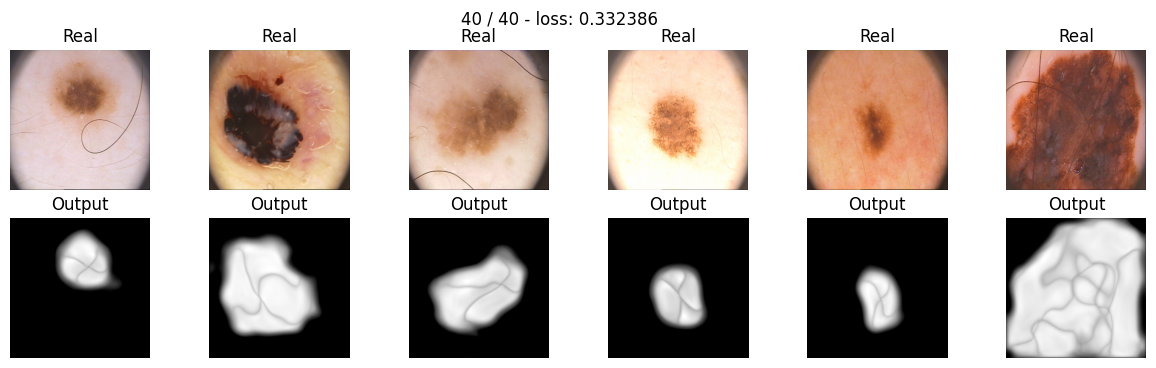

In [30]:
max_epochs = 40
optimaizer = torch.optim.Adam(p4_model.parameters(), lr=0.0001)
train(p4_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [31]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = (outputs.squeeze(1) > 0) #.byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1) > 0#.byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

In [32]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [model(X_batch.to(device)) for X_batch, _ in data]
    return np.array(Y_pred)

def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device)).to(device)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data) #, Y_label[0], Y_pred[0]

In [33]:
score_model(p4_model, iou_pytorch, data_val)

0.6233333547910055